In [1]:
import pytimber as pt
import matplotlib.pyplot as plt
from datetime import datetime, timezone, timedelta

import xobjects as xo
import xtrack as xt
import xpart as xp
import xcoll as xc

import numpy as np
import scipy.optimize as opt
import scipy.optimize as opt
from scipy.special import erf
from scipy.stats import norm


is_swan = False
if is_swan == False:
    from nxcals.spark_session_builder import get_or_create
    from nxcals.api.extraction.data.builders import DataQuery
    spark = get_or_create("My_APP")

ENVIRONMENT:
NXCALS_VERSION=1.5.8
VIRTUAL_ENV=
SPARK_HOME=/home/cmaccani/anaconda3/nxcals-bundle
SPARK_CONF_DIR=/tmp/cmaccani/nxcals-a3e0836dfec1b3b0ad0b1bd785a21fb6/conf
SPARK_DEFAULTS=/home/cmaccani/anaconda3/nxcals-bundle/conf/spark-defaults.conf
NXCALS_WORKSPACE_TEMP_DIR=/tmp/cmaccani/nxcals-a3e0836dfec1b3b0ad0b1bd785a21fb6
PACKED_VENV_FILE=/tmp/cmaccani/nxcals-a3e0836dfec1b3b0ad0b1bd785a21fb6/nxcals-python3-env.tar.gz
PYSPARK_PYTHON=/home/cmaccani/anaconda3/bin/python
PYSPARK_DRIVER_PYTHON=/bin/python
PYSPARK_DRIVER_PYTHON_OPTS=
LOCK=/tmp/cmaccani/nxcals-a3e0836dfec1b3b0ad0b1bd785a21fb6/.lock

IMPORTANT:
Rebuilding of the packed venv is required in cases there are new or modified packages provided by a user. In order to recreate the packed venv please:
        - remove the file (rm /tmp/cmaccani/nxcals-a3e0836dfec1b3b0ad0b1bd785a21fb6/nxcals-python3-env.tar.gz)
        - execute your script again (rebuild will be performed during the startup of PySpark/Python)
Target directory can

24/05/27 11:19:36 WARN Utils: Service 'sparkDriver' could not bind on port 5001. Attempting port 5002.
24/05/27 11:19:36 WARN Utils: Service 'SparkUI' could not bind on port 5201. Attempting port 5202.
24/05/27 11:19:38 WARN Utils: Service 'org.apache.spark.network.netty.NettyBlockTransferService' could not bind on port 5101. Attempting port 5102.


In [2]:
def datestring_to_timestamp_utc(date_string):
    # Parse the date string into a datetime object
    date_obj = datetime.strptime(date_string, '%Y-%m-%d %H:%M:%S') - timedelta(hours=2)
    
    # Convert the datetime object to UTC timezone if it's not already in UTC
    if date_obj.tzinfo is None or date_obj.tzinfo.utcoffset(date_obj) is None:
        date_obj = date_obj.replace(tzinfo=timezone.utc)
    else:
        date_obj = date_obj.astimezone(timezone.utc)
    
    # Extract the timestamp in seconds
    timestamp_utc = date_obj.timestamp()
    
    return timestamp_utc


def utc_timestamp_to_date_string(timestamp):
    # Convert the timestamp to a datetime object in UTC
    utc_datetime = datetime.fromtimestamp(timestamp, tz=timezone.utc)
    
    # Format the datetime object to a string
    date_string = utc_datetime.strftime('%Y-%m-%d %H:%M:%S')
    
    return date_string

In [3]:
lbd = pt.LoggingDB(source='nxcals', spark_session=spark)

In [4]:
abs_metadata = 'BLMTI.04R7.B2I10_TCSPM.B4R7.B2:LOSS_RS09'
cry_metadata = 'BLMTI.05R7.B2I10_TCPCH.A5R7.B2:LOSS_RS09'
blm_metadata = 'BLMTI.04R7.B2I10_TCSG.B4R7.B2:LOSS_RS09'
lin_metadata = 'TCSG.B4R7.B2:MEAS_MOTOR_LU'
int_metadata = 'LHC.BCTFR.A6R4.B2:BEAM_INTENSITY'
ang_metadata = 'TCPCH.A5R7.B2_ROT:YAWANGLE'
prim_metadata = 'TCP.C6R7.B2:MEAS_MOTOR_LU'

#lin_metadata = 'TCSPM.B4R7.B2:MEAS_MOTOR_LU'


In [117]:
energy = 450
scan = 1

In [114]:
# INJECTION ANGULAR SCAN
if energy == 450:
    TCP_pos = 6.685
    if scan == 1:
        tMin = '2024-05-15 13:21:27'
        tMax = '2024-05-15 13:21:27'
    elif scan == 2:
        tMin = '2024-05-15 13:25:40'
        tMax = '2024-05-15 13:27:57'
    elif scan == 3:
        tMin = '2024-05-15 13:30:19'
        tMax = '2024-05-15 13:34:05'
        
# 1 TeV ANGULAR SCAN
elif energy == 1000:
    TCP_pos =  4.715
    if scan == 1:
        tMin = '2024-05-15 15:10:38'
        tMax = '2024-05-15 15:14:01'
    elif scan == 2:
        tMin = '2024-05-15 15:15:38'
        tMax = '2024-05-15 15:18:41'

# 3 TeV ANGULAR SCAN
elif energy == 3000:
    TCP_pos =  2.86
    if scan == 1:
        tMin = '2024-05-15 16:23:30'
        tMax = '2024-05-15 16:28:51'
    elif scan == 2:
        tMin = '2024-05-15 16:31:09'
        tMax = '2024-05-15 16:35:17'
        
# 5 TeV ANGULAR SCAN
elif energy == 5000:
    TCP_pos = 2.29
    if scan == 1:
        tMin = '2024-05-15 17:38:46'
        tMax = '2024-05-15 17:42:18'
    elif scan == 2:
        tMin = '2024-05-15 17:43:43'
        tMax = '2024-05-15 17:46:44'

In [115]:
mp = 0.9382
emittance_n = 3.5e-6
gamma = energy/mp
beta = np.sqrt(1-1/(gamma*gamma))
emittance = emittance_n/(beta*gamma)


beta_CRY =  202.14283989353822
alpha_CRY = -3.542768392822383

beta_COLL =   151.98832189100114
alpha_COLL =  1.5212968243622182

deltaphi_CRY_COLL = 0.3320954889610304

CO_TCP = -5.424275667608168e-07
beta_TCP = 140.75752795686023

# TWISS of B2H
if energy == 450:
    TCP_pos = 6.685e-3
    sigma_TCP = np.sqrt(emittance*beta_TCP)
    n_sigma = (TCP_pos-CO_TCP)/sigma_TCP
    center2 =  0 #0.0025

# 1 TeV ANGULAR SCAN
elif energy == 1000:
    TCP_pos =  4.715e-3
    CRY_pos =  59.51173e-3
    sigma_TCP = np.sqrt(emittance*beta_TCP)
    n_sigma = (TCP_pos-CO_TCP)/sigma_TCP
    center2 =  0 #0.0025


# 3 TeV ANGULAR SCAN
elif energy == 3000:
    TCP_pos =  2.86e-3
    sigma_TCP = np.sqrt(emittance*beta_TCP)
    n_sigma = (TCP_pos-CO_TCP)/sigma_TCP
    center2 =  0 #0.0025

# 5 TeV ANGULAR SCAN
elif energy == 5000:
    TCP_pos = 2.29e-3
    sigma_TCP = np.sqrt(emittance*beta_TCP)
    n_sigma = (TCP_pos-CO_TCP)/sigma_TCP
    center2 =  0 #0.0025

In [118]:
energy = 1000
mp = 0.9382
emittance_n = 3.5e-6
gamma = energy/mp
beta = np.sqrt(1-1/(gamma*gamma))
emittance = emittance_n/(beta*gamma)
(59.51173e-3-5.224817773694159e-07)/np.sqrt(emittance*beta_CRY) #TCPCH.A5R7.B2_LIN:LVDTPOSITION

73.04453841312744

- TCP sigma not at 6 ???
- motor crystal? position value??



#### Angular Scan

In [42]:
cry_blm_background = lbd.get(cry_metadata, '2024-05-15 12:30:00', '2024-05-15 12:33:30')
bkg_blm_cry = np.mean( cry_blm_background[cry_metadata][1])

/home/cmaccani/anaconda3/lib/python3.11/site-packages/pytimber/data.py:270: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ).dt.to_pydatetime()


In [43]:
data = lbd.get([cry_metadata, ang_metadata, int_metadata, abs_metadata],  tMin , tMax )

/home/cmaccani/anaconda3/lib/python3.11/site-packages/pytimber/data.py:270: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ).dt.to_pydatetime()
/home/cmaccani/anaconda3/lib/python3.11/site-packages/pytimber/data.py:270: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ).dt.to_pydatetime()
/home/cmaccani/anaconda3/lib/python3.11/site-packages/pytimber/data.py:270: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  )

In [58]:
mot =  data[ang_metadata][1]
time = data[ang_metadata][0]
signal =  data[cry_metadata][1]
beam_intensity = data[int_metadata][1]
absorber_signal = data[abs_metadata][1]

/tmp/cmaccani/ipykernel_35239/424237954.py:1: RankWarning: Polyfit may be poorly conditioned
  p = np.polyfit(time, beam_intensity, 5)


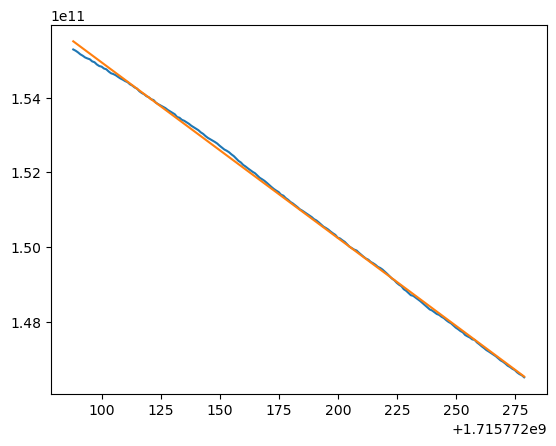

In [59]:
p = np.polyfit(time, beam_intensity, 5)
plt.plot(time, beam_intensity)
plt.plot(time, np.polyval(p, time))

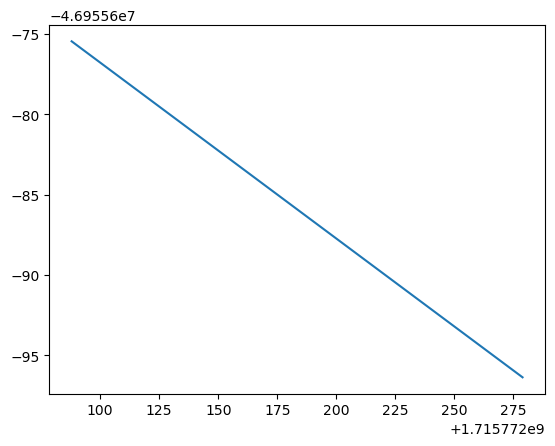

In [60]:
q = np.polyder(p)
plt.plot(time, np.polyval(q, time))

In [61]:
t0 = time[0]
time_scan = [i - t0 for i in time]

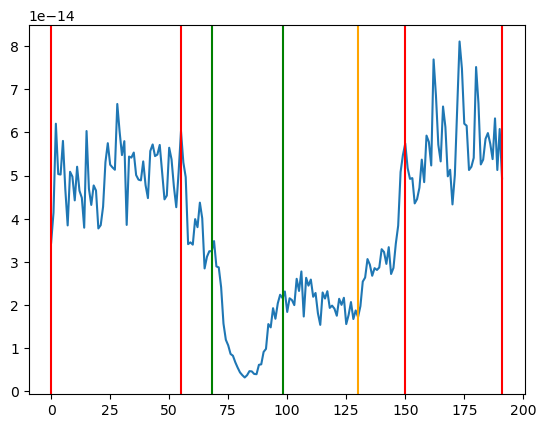

In [101]:
q = np.polyder(p)

cry_blm = [(signal[i]-bkg_blm_cry)/abs(np.polyval(q, time[i])) for i in range(len(signal))]
#cry_blm = [(signal[i]-bkg_blm_cry) for i in range(len(signal))]
plt.plot(time_scan, cry_blm)
#plt.plot(mot, cry_blm)
plt.axvline(0, color = 'r')
plt.axvline(55, color = 'r')
plt.axvline(68, color = 'g')
plt.axvline(98, color = 'g')
plt.axvline(130, color = 'orange')
plt.axvline(150, color = 'r')
plt.axvline(time_scan[-1], color = 'r')

In [105]:
amorph_UL = mot[np.where(time_scan==min(time_scan, key=lambda x: abs(x - 0)))] 
amorph_UR = mot[np.where(time_scan==min(time_scan, key=lambda x: abs(x - 55)))] 
chann_L = mot[np.where(time_scan==min(time_scan, key=lambda x: abs(x - 68)))] 
chann_R = mot[np.where(time_scan==min(time_scan, key=lambda x: abs(x - 98)))] 
VR_R = mot[np.where(time_scan==min(time_scan, key=lambda x: abs(x - 130)))] 
amorph_DL = mot[np.where(time_scan==min(time_scan, key=lambda x: abs(x - 150)))] 
amorph_DR = mot[np.where(time_scan==time_scan[-1])]

print(np.abs(chann_R - VR_R)[0])

35.20046858978276


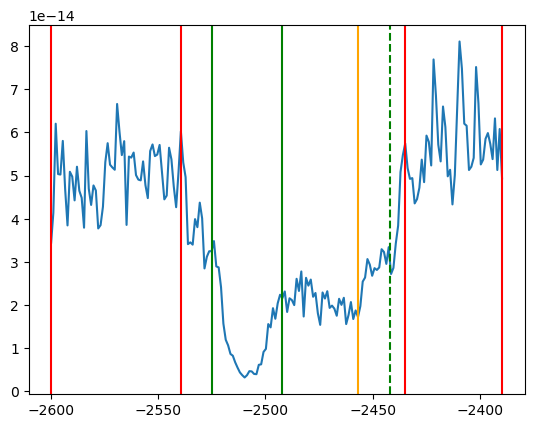

In [106]:
plt.plot(mot, cry_blm)
#plt.plot(mot, cry_blm)
plt.axvline(amorph_UL, color = 'r')
plt.axvline(amorph_UR, color = 'r')
plt.axvline(chann_L, color = 'g')
plt.axvline(chann_R, color = 'g')
plt.axvline(VR_R, color = 'orange')
plt.axvline(amorph_DL, color = 'r')
plt.axvline(amorph_DR, color = 'r')
plt.axvline(chann_R+50, color = 'g', linestyle = '--')

- How tho choose these bands? 
- what should the bending angle?
- (NORMALIZATION in order to define a reduction factor)

In [107]:
amorph_mean = np.mean(np.concatenate([cry_blm[np.where(mot == amorph_DL)[0][0]:np.where(mot == amorph_DR)[0][0]], 
                        cry_blm[np.where(mot == amorph_UL)[0][0]:np.where(mot == amorph_UR)[0][0]] ]))
cry_sgn_blm = np.array([i/amorph_mean for i in cry_blm])

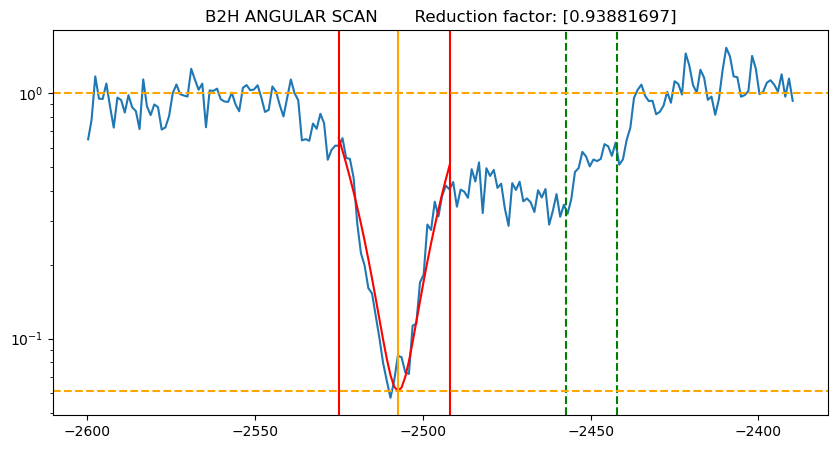

In [108]:
chann_ang_range = mot[np.where((mot >= chann_L) & (mot <= chann_R))]
chann_signal = cry_sgn_blm[np.where((mot >= chann_L) & (mot <= chann_R))]
coeff_chann_well = np.polyfit(chann_ang_range, chann_signal, 2)

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(mot, cry_sgn_blm)
ax.plot(chann_ang_range, np.polyval(coeff_chann_well, chann_ang_range), 'r')
ax.axvline(chann_L, color = 'r')
ax.axvline(chann_R, color = 'r')
# Define the polynomial coefficients and the constant value
chann_align_angle = np.roots(np.polyder(coeff_chann_well))



ax.axvline(chann_align_angle, color = 'orange')
ax.axvline(chann_R+50, color = 'g', linestyle = '--')
ax.axvline(chann_align_angle+50, color = 'g', linestyle = '--')
#ax.axvline(amorph_DL, color = 'r', linestyle = '--')
ax.axhline(np.polyval(coeff_chann_well, chann_align_angle), color = 'orange', linestyle = '--')

ax.set_title(f'B2H ANGULAR SCAN       Reduction factor: {1-np.polyval(coeff_chann_well, chann_align_angle)}')

#ax.axvline(min(np.polyval(coeff_chann_well, chann_ang_range)))
#ax_abs = ax.twinx()
#ax_abs.plot(mot, absorber_signal, 'g')
#ax_abs.set_ylim (-2e-4, 1.2e-4)
plt.axhline(1, color = 'orange', linestyle = '--')
plt.yscale('log')

In [109]:
print('Reduction factor:', 1-np.polyval(coeff_chann_well, chann_align_angle))

Reduction factor: [0.93881697]


In [92]:
720+663

1383

# Linear Scan

In [ ]:
energy = 1000
scan = 1

In [ ]:
# LINEAR SCAN

# 1 TeV LINEAR SCAN
if energy == 1000:
    TCP_pos =  4.715
    if scan == 1:
        tMin_bkg = '2024-05-15 15:25:07'
        tMax_bkg = '2024-05-15 15:26:27'
        tMin = '2024-05-15 15:26:32'
        tMax = '2024-05-15 15:31:12'

# 3 TeV LINEAR SCAN
elif energy == 3000:
    TCP_pos =  2.86
    if scan == 1:
        tMin_bkg = '2024-05-15 16:41:25'
        tMax_bkg = '2024-05-15 16:42:25'  
        tMin = '2024-05-15 16:42:30'
        tMax = '2024-05-15 16:46:55'
    elif scan == 2:
        tMin_bkg = '2024-05-15 16:50:32'
        tMax_bkg = '2024-05-15 16:51:07'
        tMin = '2024-05-15 16:51:12'
        tMax = '2024-05-15 16:55:32'

# 5 TeV LINEAR SCAN
elif energy == 5000:
    TCP_pos = 2.29
    if scan == 1:
        tMin_bkg = '2024-05-15 17:55:00'
        tMax_bkg = '2024-05-15 17:55:30'
        tMin = '2024-05-15 17:55:35'
        tMax = '2024-05-15 18:00:30'
    elif scan == 2:
        tMin_bkg = '2024-05-15 18:01:53'
        tMax_bkg = '2024-05-15 18:02:04'
        tMin = '2024-05-15 18:02:08'
        tMax = '2024-05-15 18:06:28'


##### Checks

In [ ]:
data = lbd.get(blm_metadata, tMin_bkg , tMax )

/home/cmaccani/anaconda3/lib/python3.11/site-packages/pytimber/data.py:270: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ).dt.to_pydatetime()


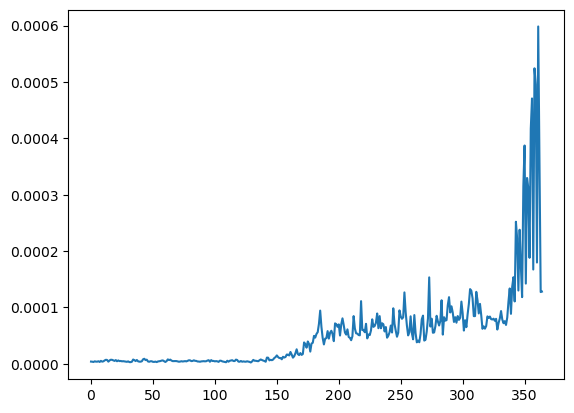

In [ ]:
time = data[blm_metadata][0]
signal =  data[blm_metadata][1]

t0 = time[0]
time = [i - t0 for i in time]
plt.plot(time, signal)
#plt.axvline(11)
#plt.axvline(15)

In [ ]:
print(utc_timestamp_to_date_string(t0 +60*60*2 + 11))
print(utc_timestamp_to_date_string(t0 +60*60*2 + 15))

2024-05-15 15:25:18
2024-05-15 15:25:22


In [ ]:
time = [i + t0 for i in time]

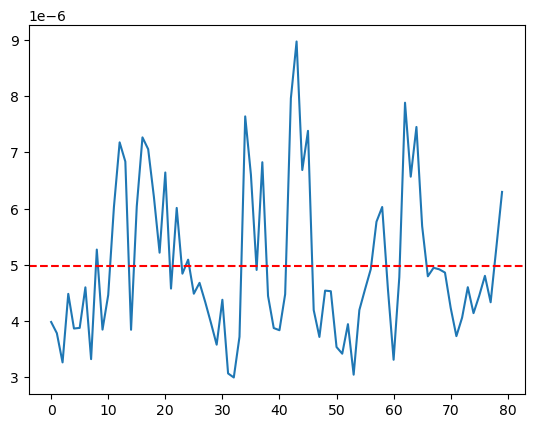

In [ ]:
BLM_bkg = signal[np.where((np.round(time) ==  datestring_to_timestamp_utc(tMin_bkg)))[0][0]:np.where((np.round(time) ==  datestring_to_timestamp_utc(tMax_bkg)))[0][0]]
time_bkg = time[np.where((np.round(time) ==  datestring_to_timestamp_utc(tMin_bkg)))[0][0]:np.where((np.round(time) ==  datestring_to_timestamp_utc(tMax_bkg)))[0][0]]
Delta_time_bkg = np.array([i - time_bkg[0] for i in time_bkg])
bkg_mean = np.mean(BLM_bkg)

fig, ax = plt.subplots()
ax.plot(Delta_time_bkg, BLM_bkg)
ax.axhline(y=bkg_mean, color='r', linestyle='--')

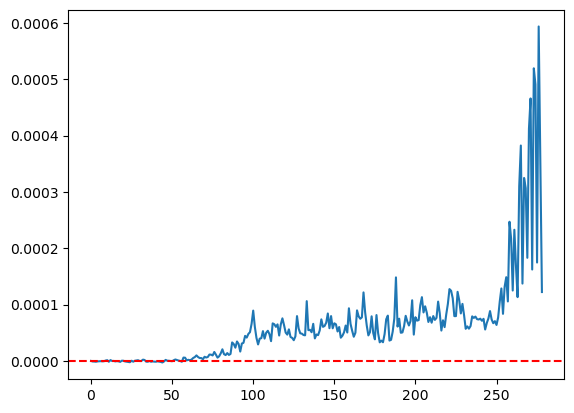

In [ ]:
BLM_scan = signal[np.where((np.round(time) ==  datestring_to_timestamp_utc(tMin)))[0][0]:np.where((np.round(time) ==  datestring_to_timestamp_utc(tMax)-1))[0][0]]
time_scan = time[np.where((np.round(time) ==  datestring_to_timestamp_utc(tMin)))[0][0]:np.where((np.round(time) ==  datestring_to_timestamp_utc(tMax)-1))[0][0]]
Delta_time_scan= np.array([i - time_scan[0] for i in time_scan])
BLM_scan = BLM_scan - bkg_mean

fig, ax = plt.subplots()
ax.plot(Delta_time_scan, BLM_scan)
ax.axhline(y=0, color='r', linestyle='--')

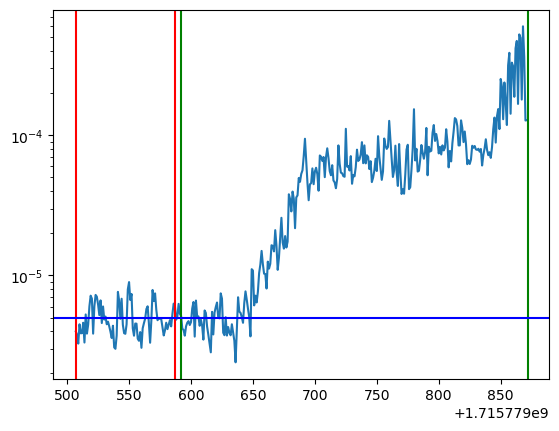

In [ ]:
fig, ax = plt.subplots()
plt.plot(time, signal)
ax.axvline(datestring_to_timestamp_utc(tMin_bkg), color = 'r')
ax.axvline(datestring_to_timestamp_utc(tMax_bkg), color = 'r')
ax.axvline(datestring_to_timestamp_utc(tMin), color = 'g')
ax.axvline(datestring_to_timestamp_utc(tMax), color = 'g')
ax.axhline(bkg_mean, color = 'b')
ax.set_yscale('log')

#### Analysis

/home/cmaccani/anaconda3/lib/python3.11/site-packages/pytimber/data.py:270: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ).dt.to_pydatetime()


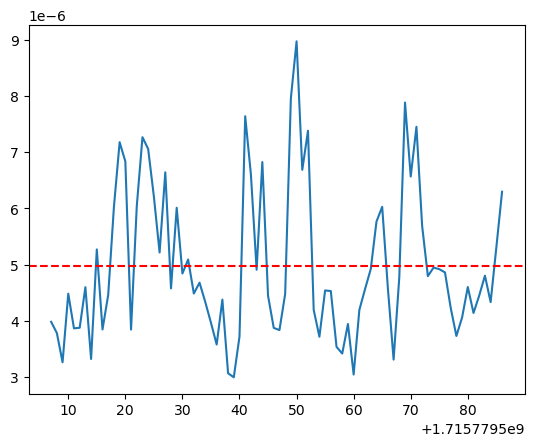

In [ ]:
Bkg_data = lbd.get(blm_metadata, tMin_bkg , tMax_bkg )
DeltaBLM_bkg = Bkg_data[blm_metadata][0]
BLM_bkg =  Bkg_data[blm_metadata][1]

fig, ax = plt.subplots()
ax.plot(DeltaBLM_bkg, BLM_bkg)
ax.axhline(y=bkg_mean, color='r', linestyle='--')

In [ ]:
# set delt ainterval from first measure
DeltaBLM_bkg = np.array([i - DeltaBLM_bkg[0] for i in DeltaBLM_bkg])
bkg_mean = np.mean(BLM_bkg)

/home/cmaccani/anaconda3/lib/python3.11/site-packages/pytimber/data.py:270: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ).dt.to_pydatetime()


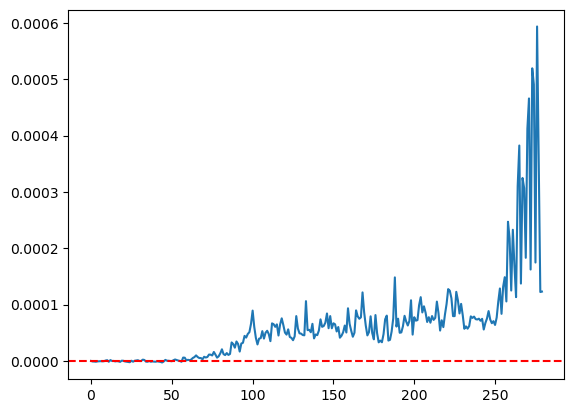

In [ ]:
Scan_data = lbd.get(blm_metadata, tMin, tMax)
DeltaBLM = Scan_data[blm_metadata][0]
SignalBLM =  Scan_data[blm_metadata][1]


DeltaBLM = np.array([i - DeltaBLM[0] for i in DeltaBLM])
SignalBLM = SignalBLM - bkg_mean

fig, ax = plt.subplots()
ax.plot(DeltaBLM, SignalBLM)
ax.axhline(y=0, color='r', linestyle='--')

/home/cmaccani/anaconda3/lib/python3.11/site-packages/pytimber/data.py:270: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ).dt.to_pydatetime()


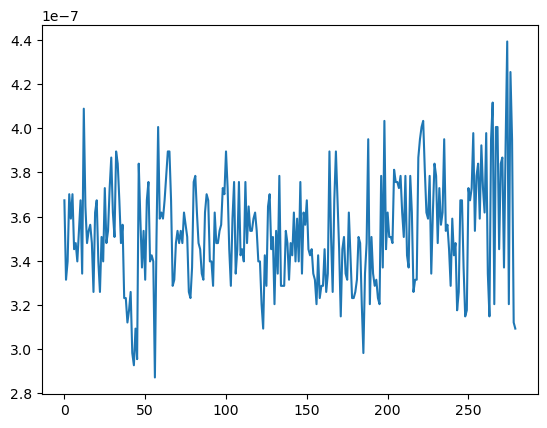

In [ ]:
SignalCRY = lbd.get(cry_metadata, tMin, tMax )[cry_metadata][1]

plt.plot(DeltaBLM, SignalCRY)

/home/cmaccani/anaconda3/lib/python3.11/site-packages/pytimber/data.py:270: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ).dt.to_pydatetime()


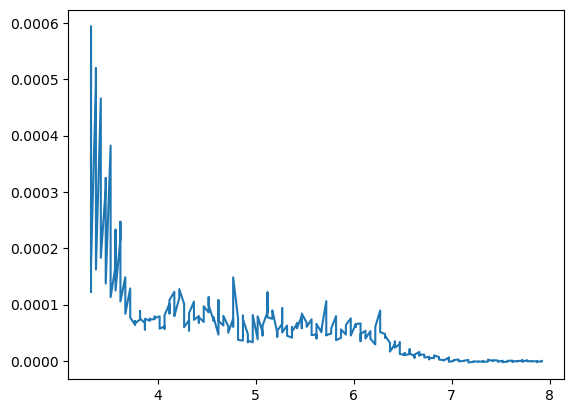

In [ ]:
CollPos = lbd.get(lin_metadata, tMin , tMax )[lin_metadata][1]

fig, ax = plt.subplots()
ax.plot(CollPos, SignalBLM)
#ax.set_ylim(0, 0.00004)

In [ ]:
BeamInt = lbd.get(int_metadata, tMin, tMax )[int_metadata][1]

/home/cmaccani/anaconda3/lib/python3.11/site-packages/pytimber/data.py:270: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ).dt.to_pydatetime()


In [ ]:
MeanCollPos = []
SignalBLMRedu = []
SignalBLMErr = []
SignalCRYRedu = []
BeamIntRedu = []
DeltaBLMRedu = []

i = 1

while i < len(CollPos):
    count = 1
    SumPos = CollPos[i-1]
    BLMmean = []
    CRYmean = []
    Intmean = []
    DeltaBLMmean = []
    BLMmean.append(SignalBLM[i-1])
    CRYmean.append(SignalCRY[i-1])
    Intmean.append(BeamInt[i-1])
    DeltaBLMmean.append(DeltaBLM[i-1])

    # if the absorber stays in the same position for more than one measurement, compoute the mean of the signals
    while CollPos[i] == CollPos[i-1]:
        
        count += 1
        SumPos += CollPos[i]
        BLMmean.append(SignalBLM[i])
        CRYmean.append(SignalCRY[i])
        Intmean.append(BeamInt[i])
        DeltaBLMmean.append(DeltaBLM[i])
        i = i+1
        if i == len(CollPos):
            break
        
    MeanCollPos.append(round(SumPos/count,3))
    SignalBLMRedu.append(sum(BLMmean)/count)
    SignalBLMErr.append((max(BLMmean)-min(BLMmean))/2.)
    SignalCRYRedu.append(sum(CRYmean)/count)
    BeamIntRedu.append(sum(Intmean)/count)
    DeltaBLMRedu.append(round(sum(DeltaBLMmean)/count,3))
    i = i+1

In [ ]:
"""line_path = './input_files/2024_Run3/injection_b1.json'
coll_file = './input_files/colldbs/injection.yaml'

line = xt.Line.from_json(line_path)
#context = xo.ContextCpu() 
#coll_manager = xc.CollimatorManager.from_yaml(coll_file, line=line, beam=beam, _context=context, ignore_crystals=False)
#coll_names = coll_manager.collimator_names
#not_install = ['tccs.5r3.b2', 'tccp.4l3.b2', 'target.4l3.b2']
#everest_colls = [name for name in coll_names if name not in not_install]
#coll_manager.install_everest_collimators(names=everest_colls, verbose=False)
tw = line.twiss(method = '4d')

CRY_name = 'TCPCV.A6L7.B1'.lower()
COLL_name = 'TCSG.D4L7.B1'.lower()

deltaphi = float(tw[tw.name == COLL_name]['muy'])% 1* 2*np.pi - float(tw[tw.name == CRY_name]['muy'])% 1* 2*np.pi


beta1 = tw['bety',CRY_name]
beta2 = tw['bety',COLL_name]
alpha1 = tw['alphy',CRY_name]
alpha2 = tw['alphy',COLL_name]"""

"line_path = './input_files/2024_Run3/injection_b1.json'\ncoll_file = './input_files/colldbs/injection.yaml'\n\nline = xt.Line.from_json(line_path)\n#context = xo.ContextCpu() \n#coll_manager = xc.CollimatorManager.from_yaml(coll_file, line=line, beam=beam, _context=context, ignore_crystals=False)\n#coll_names = coll_manager.collimator_names\n#not_install = ['tccs.5r3.b2', 'tccp.4l3.b2', 'target.4l3.b2']\n#everest_colls = [name for name in coll_names if name not in not_install]\n#coll_manager.install_everest_collimators(names=everest_colls, verbose=False)\ntw = line.twiss(method = '4d')\n\nCRY_name = 'TCPCV.A6L7.B1'.lower()\nCOLL_name = 'TCSG.D4L7.B1'.lower()\n\ndeltaphi = float(tw[tw.name == COLL_name]['muy'])% 1* 2*np.pi - float(tw[tw.name == CRY_name]['muy'])% 1* 2*np.pi\n\n\nbeta1 = tw['bety',CRY_name]\nbeta2 = tw['bety',COLL_name]\nalpha1 = tw['alphy',CRY_name]\nalpha2 = tw['alphy',COLL_name]"

In [ ]:
mp = 0.9382    #GeV
emittance_n = 3.5e-6

gamma = energy/mp
beta = np.sqrt(1-1/gamma**2)
emittance = emittance_n/(beta*gamma)

Theta = []
ActualPos = []

for step in range(len(MeanCollPos)):
	tActualPos = (MeanCollPos[step]-center2)
	tTheta = -((tActualPos*1e-3 - n_sigma_CRY*np.sqrt(emittance*beta_COLL)*np.cos(deltaphi_CRY_COLL))/(np.sqrt(beta_CRY*beta_COLL)*np.sin(deltaphi_CRY_COLL)))*1e6

	ActualPos.append(round(tActualPos,3))
	Theta.append(tTheta)
	#print(ActualPos[step], MeanCollPos[step])


In [ ]:
# write output file
import csv
scan = ''
config = ''
iFilePlot = 'LinearScanPlot_'+config+'_'+scan+'.dat'
oBeamInt = 'BeamIntensityFit_'+config+'_'+scan+'.png'
oBLMNorm = 'BLMSignalNorm_'+config+'_'+scan+'.png'
oBLMFit = 'BLMSignalNormFit_'+config+'_'+scan+'_FT.png'
oScanNorm = 'LinearScanPlotNorm_'+config+'_'+scan+'.dat'

with open(iFilePlot,'w') as oFile:
	oFile.write('# DeltaBLM CollPos ActualPos Theta SignalBLM ErrBLM BeamInt SignalCry\n')
	writer = csv.writer(oFile,delimiter='\t')
	writer.writerows(zip(DeltaBLMRedu,MeanCollPos,ActualPos,Theta,SignalBLMRedu,SignalBLMErr,BeamIntRedu,SignalCRYRedu))

# Fit and Plot ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

with open(iFilePlot,'r') as readPlot:
	for line in readPlot:
		if line.split(' ')[0] != '#':
			t, collpos, actualpos, Ttheta, signalblm, errblm, beamint, signalcry = np.genfromtxt(readPlot, unpack=True)
			#DeltaBLMRedu,MeanCollPos,ActualPos,Theta,SignalBLMRedu,SignalBLMErr,BeamIntRedu,SignalCRYRedu


7.87 -9.377485275268553e-07
3.32 0.00027412171192169185
3.37 0.0003907833411534627
3.42 0.00035368353341420493
3.47 0.00025628445504506425
3.52 0.0002686611843744913
3.57 0.00017541039091746008
3.62 0.00019003986174265545
3.67 0.0001213611660639445
3.72 0.00010381979440053303
3.77 6.727511666615804e-05
3.82 7.924861723581949e-05
3.87 6.605806547800699e-05
3.92 7.340180021921794e-05
3.97 7.653280709584554e-05


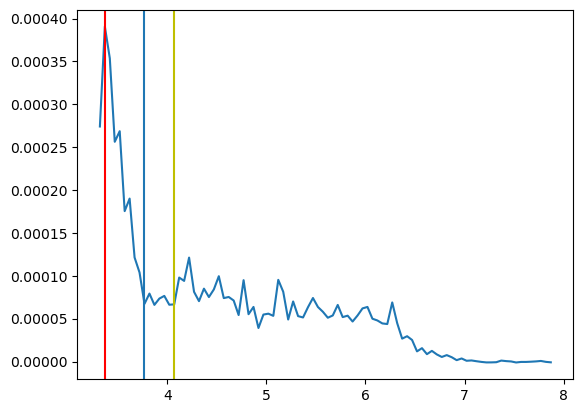

In [ ]:
for i in range(15):
    print(actualpos[-i], signalblm[-i])
    

plt.plot(actualpos, signalblm)
#plt.xlim(3,4)
plt.axvline(3.77)
plt.axvline(3.37, color = 'r')
plt.axvline(3.77+0.3, color = 'y')

In [ ]:
norm_l1 = 3.77
norm_l2 = 3.77
# To be understood 
meanlim = -0.3 #?????


/tmp/cmaccani/ipykernel_14548/2963294364.py:41: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  f0.show()


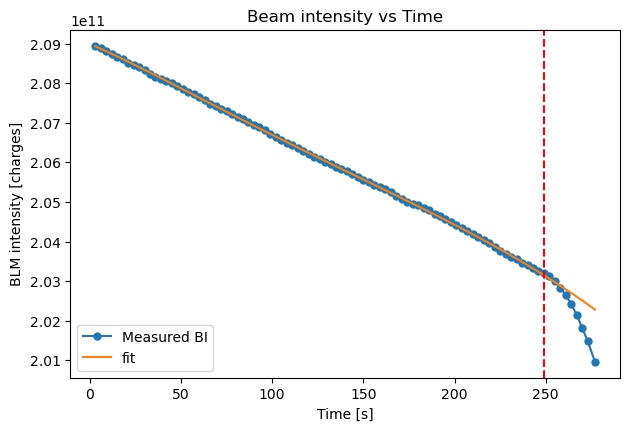

In [ ]:
# ------------- BEAM INTENSITY PLOT -------------------


for i in range(len(t)):
    if actualpos[i] == norm_l1:
        t1 = t[i]
    if actualpos[i] == norm_l2:
        t2 = t[i]
        
# time at which we reach the spike
t_lim =  (t1+t2)/2. 

# interval time to fit
t_fit = []
beamint_fit = []

for i in range(len(t)):
    if t[i] <= t_lim:
        t_fit.append(t[i])
        beamint_fit.append(beamint[i])

theta = [i for i in Ttheta]

f0 = plt.figure(0)
plt.title('Beam intensity vs Time')
plt.plot(t, beamint, label='Measured BI', marker='o', markersize=5)

# Least squares polynomial fit. Polynomial coefficients, highest power first. 
#p = np.polyfit(t_fit, beamint_fit, 3)
p = np.polyfit(t_fit, beamint_fit, 5)

#Evaluate a polynomial at specific values.
y = np.polyval(p, t)
plt.plot(t, y, label='fit')
plt.xlabel('Time [s]')
plt.ylabel('BLM intensity [charges]')
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.axvline(t_lim, color='r', linestyle='--')
plt.legend()

f0.show()
f0.tight_layout(rect=[0, 0.03, 1, 0.95])
#f0.savefig(oBeamInt)



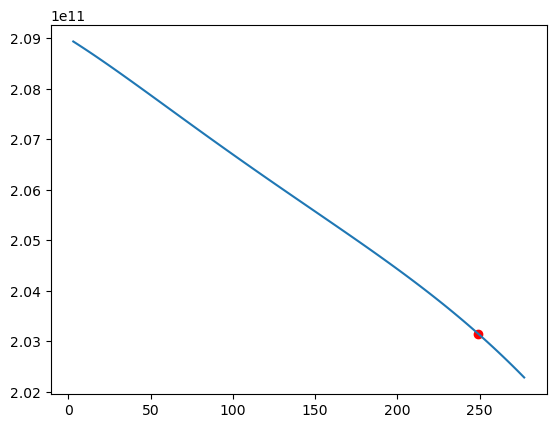

In [ ]:
for i in range(len(t)):
    if actualpos[i] == norm_l1:
        x  = t[i]
        y = np.polyval(p,t[i])
        #y = np.polyval(q,t[i])

plt.plot(x,y, 'ro')

#plt.plot(t, np.polyval(q,t))
plt.plot(t, np.polyval(p,t))

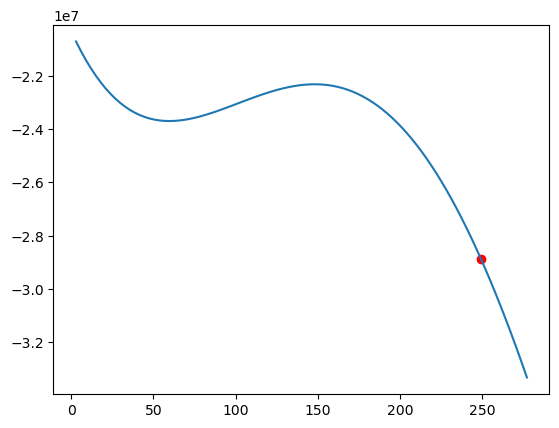

In [ ]:
q = np.polyder(p)


for i in range(len(t)):
    if actualpos[i] == norm_l1:
        x  = t[i]
        #y = np.polyval(p,t[i])
        y = np.polyval(q,t[i])

plt.plot(x,y, 'ro')

plt.plot(t, np.polyval(q,t))
#plt.plot(t, np.polyval(p,t))

In [ ]:
normal

-3.0600302732633133e-12

3.77 4.07
4.07 6.666751168568928e-05 -26605178.860213593
4.02 6.623022022247315e-05 -26947135.195119906
3.97 7.653280709584554e-05 -27302887.316214822
3.92 7.340180021921794e-05 -27672389.293957673
3.87 6.605806547800699e-05 -28055579.383714028
3.82 7.924861723581949e-05 -28452380.02575574
3.77 6.727511666615804e-05 -28862697.8452609


/tmp/cmaccani/ipykernel_14548/462500868.py:51: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  f1.show()


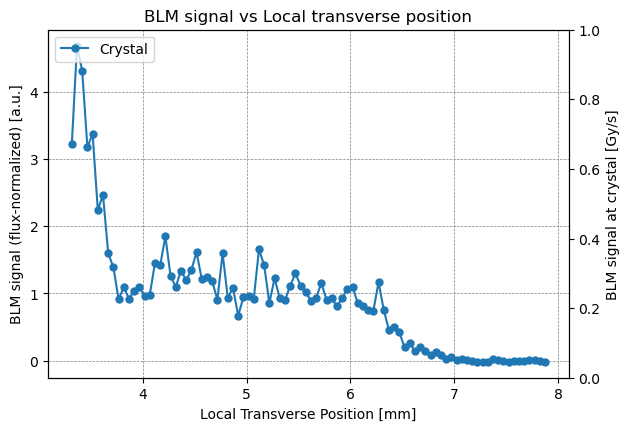

In [ ]:
#Return the derivative of the specified order of a polynomial.
# q is a n-1 order polynomial
q = np.polyder(p)
signalblm_norm = []
errblm_norm = []


for i in range(len(t)):
    if actualpos[i] == norm_l1:
        norm_s1 = signalblm[i]/np.polyval(q,t[i])
    if actualpos[i] == norm_l2:
        norm_s2 = signalblm[i]/np.polyval(q,t[i])
        
# normalize BLM to derivative of beam intensity   WHY?
normal = (norm_s1+norm_s2)/2.
norm_l = (norm_l1+norm_l2)/2.
# normal = normal*2.5/5
# print normal

count_norm = 0
mean_norm = []
print(norm_l, norm_l-meanlim)
for i in range(len(actualpos)):
	#if actualpos[i] <= norm_l and actualpos[i] >= norm_l-meanlim:
	if actualpos[i] >= norm_l and actualpos[i] <= norm_l-meanlim:
		print(actualpos[i], signalblm[i], np.polyval(q,t[i]))
		mean_norm.append(signalblm[i]/np.polyval(q,t[i]))
		count_norm += 1
normal = sum(mean_norm)/count_norm

for i in range(len(t)):
	signalblm_norm.append(signalblm[i]/abs(np.polyval(q,t[i])*normal))
	errblm_norm.append(errblm[i]/abs(np.polyval(q,t[i])*normal))

f1 = plt.figure(1)
ax3 = f1.add_subplot(111)
ax4 = ax3.twinx()
plt.title('BLM signal vs Local transverse position')
ax3.plot(actualpos, signalblm_norm, marker='o', markersize=5, label='Crystal')
#ax4.plot(actualpos, signalcry, marker='o', markersize=5, color='red', label='Absorber')
ax3.set_xlabel('Local Transverse Position [mm]')
ax3.set_ylabel('BLM signal (flux-normalized) [a.u.]')
ax4.set_ylabel('BLM signal at crystal [Gy/s]')
ax3.grid(color='gray', linestyle='--', linewidth=0.5)
ax4.yaxis.grid(False)
lines3, labels3 = ax3.get_legend_handles_labels()
lines4, labels4 = ax4.get_legend_handles_labels()
plt.legend(lines3+lines4, labels3+labels4, fontsize=10, loc=2)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

f1.show()
f1.tight_layout(rect=[0, 0.03, 1, 0.95])
#f1.savefig(oBLMNorm)

Height:  69.57186799913843  a.u.
Mean:  -3.5  mm
Sigma:  0.01  mm


/home/cmaccani/anaconda3/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


NameError: name 'sigma1' is not defined

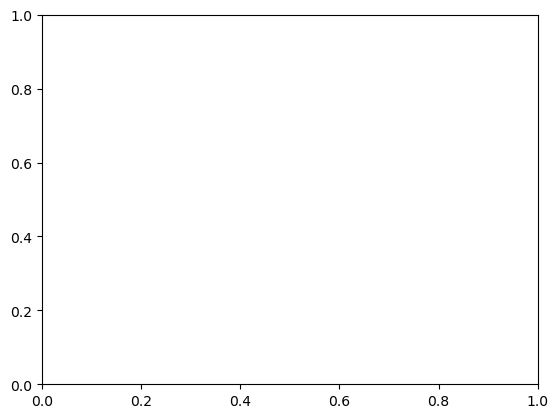

In [ ]:
f2 = plt.figure(2)
maxfit = 6.677
# raw_input()

def erfunc(x,a,b,c,d):
	return a+(b/2.0)*erf((x-c)/(d*np.sqrt(2.0)))
	
param0 = [0.0,1,-3.5,0.01]

ax1 = f2.add_subplot(111)
# plt.title('BLM signal vs Local transverse position of absorber', fontsize=14, y=1.20)

actualpos_filt = []
signalblm_filt = []
errblm_filt = []
for i in range(len(actualpos)):
	if (actualpos[i]<maxfit):
		actualpos_filt.append(actualpos[i])
		signalblm_filt.append(signalblm_norm[i])
		errblm_filt.append(errblm_norm[i])

params, extras = opt.curve_fit(erfunc, actualpos_filt, signalblm_filt, p0=param0, sigma=errblm_filt)

print('Height: ', abs(params[1]), ' a.u.')
print('Mean: ', params[2], ' mm')
print('Sigma: ', abs(params[3]), ' mm')

signalblm_notnorm=[]
for i in signalblm_norm:
	signalblm_notnorm.append(i*normal)

with open(oScanNorm,'w') as oFile:
	oFile.write('# Pos SignalBLM SignalBLMNorm\n')
	writer = csv.writer(oFile,delimiter='\t')
	writer.writerows(zip(actualpos,signalblm_notnorm,signalblm_norm))


if config == 'B2V' and scan == '3':
	xenv = 1.163
else:
	xenv = abs(norm_l)
xdef = abs(params[2])
deltax = (xdef-xenv)*1.0e-3

theta_calc = (deltax-sigma1*np.sqrt(emittance*beta2)*(np.cos(deltaphi)-1))/(np.sqrt(beta2*beta1)*np.sin(deltaphi))
print('Calculated theta [urad]: ', round(theta_calc*1.0e6,3))


x1 = -xenv
y1 = 0
x2 = -xdef
y2 = theta_calc*1.0e6
m = (y2-y1)/(x2-x1)
q = y1-m*x1


actualpos_pos = [-i for i in actualpos]
actualpos_conv = [m*(-i)+q for i in actualpos_pos]


# ax1.plot(actualpos, abs(params[1])*norm.pdf(actualpos,params[2],abs(params[3])), label='Ch beam profile', color='green')
ax3 = ax1.twiny()
ax1.errorbar(actualpos_pos, signalblm_norm, yerr=errblm_norm, label='Data', marker='o', markersize=5)
ax1.plot(actualpos_pos, erfunc(actualpos, *params), label='Fit', zorder=10)
ax3.plot(actualpos_conv, signalblm_norm, alpha=0.0)
ticks = ax3.get_xticks()
ax3.set_xticklabels([int(abs(tick)) for tick in ticks])
ax1.tick_params(axis='both', which='major', labelsize=12)
ax3.tick_params(axis='both', which='major', labelsize=12)
ax1.set_xlabel('Linear Transverse Position [mm]', fontsize=14)
ax1.set_ylabel('BLM signal (normalized) [a.u.]', fontsize=14)
# ax1.set_ylabel('Channeled beam profile [a.u.]', fontsize=12)
ax3.set_xlabel('Deflection angle [$\mu$rad]', fontsize=14)
ax1.hlines(y=1, xmin=-norm_l, xmax=-norm_l+meanlim, linewidth=2, color='green')
# ax1.get_yaxis().set_visible(False)
if config == 'B2V' and scan == '3':
	ax1.set_ylim(0,5)
else:
	ax1.set_ylim(0,2.5)
ax1.grid(color='gray', linestyle='--', linewidth=0.5)
# ax1.yaxis.grid(False)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
lines1, labels1 = ax1.get_legend_handles_labels()
plt.legend(lines1, labels1, fontsize=14, loc=1)
ax1.grid(color='gray', linestyle='--', linewidth=0.5)
textstr = 'Bending angle: %.2f $\mu$rad\nEfficiency: %.2f' % (round(theta_calc*1.0e6,3),round(abs(params[1])*100,2),)+'%'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax1.text(0.5, 0.5, textstr, transform=ax1.transAxes, fontsize=12, verticalalignment='bottom', bbox=props)

f2.show()
f2.tight_layout(rect=[0, 0.03, 1, 0.95])
#f2.savefig(oBLMFit)

/tmp/cmaccani/ipykernel_14548/623642714.py:9: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  f3.show()


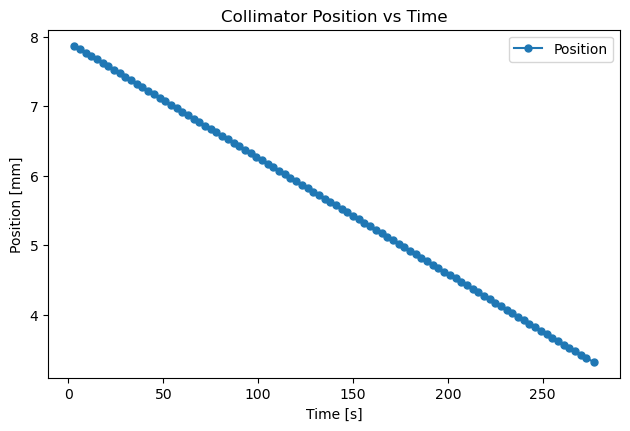

In [ ]:
f3 = plt.figure(3)
plt.title('Collimator Position vs Time')
plt.plot(t, collpos, label='Position', marker='o', markersize=5)
plt.xlabel('Time [s]')
plt.ylabel('Position [mm]')
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.legend()

f3.show()
f3.tight_layout(rect=[0, 0.03, 1, 0.95])
#f0.savefig(oBeamInt)

In [ ]:
angle = []
for i in range(len(actualpos)):
#	print (((actualpos_pos[i]-xenv)*1.0e-3)-sigma1*np.sqrt(emittance*beta2)*(np.cos(deltaphi)-1))/(np.sqrt(beta2*beta1)*np.sin(deltaphi))*1.0e6
	angle.append(-(((actualpos_pos[i]-xenv)*1.0e-3)-sigma1*np.sqrt(emittance*beta2)*(np.cos(deltaphi)-1))/(np.sqrt(beta2*beta1)*np.sin(deltaphi))*1.0e6)

angle_filt = []
signalblm_filt_2 = []
errblm_filt_2 = []
for i in range(len(angle)):
	if config == 'B2H':
		if (angle[i]<-30):
			angle_filt.append(angle[i])
			signalblm_filt_2.append(signalblm_norm[i])
			errblm_filt_2.append(errblm_norm[i])
	else:
		if (angle[i]<-20):
			angle_filt.append(angle[i])
			signalblm_filt_2.append(signalblm_norm[i])
			errblm_filt_2.append(errblm_norm[i])

param0_2 = param0

#params_2, extras_2 = opt.curve_fit(erfunc, angle_filt, signalblm_filt_2, p0=param0_2, sigma=errblm_filt_2)
"""print('Height: ', abs(params_2[1]), ' a.u.')
print('Mean: ', params_2[2], ' urad')
print('Sigma: ', abs(params_2[3]), ' urad')"""

f4 = plt.figure(4)
ax4 = f4.add_subplot(111)
ax5 = ax4.twinx()
# ax5.get_yaxis().set_visible(False)
ax4.errorbar(angle, signalblm_norm, yerr=errblm_norm, label='Data', marker='o', markersize=5)
#ax5.plot(angle, abs(params_2[1])*norm.pdf(angle,params_2[2],abs(params_2[3])), label='Ch beam profile', color='green')
#ax4.plot(angle, erfunc(angle, *params_2), label='Fit', zorder=10)
ax4.set_xlabel('Deflection angle [$\mu$rad]', fontsize=14)
ax4.set_ylabel('BLM signal (normalized) [a.u.]', fontsize=14)
ax5.set_ylabel('Channeled beam profile [a.u.]', fontsize=14)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
if config == 'B2V' and scan == '3':
	ax4.set_ylim(0,5)
	ax5.set_ylim(0,2.5)
else:
	ax4.set_ylim(0,2.5)
	ax5.set_ylim(0,0.4)
ax4.grid(color='gray', linestyle='--', linewidth=0.5)

f4.show()
f4.tight_layout(rect=[0, 0.03, 1, 0.95])
#f4.savefig('BLMSignalNormFit__'+config+'_'+scan+'FT_withChprofile.png')

NameError: name 'actualpos_pos' is not defined